In [123]:
import findspark
import matplotlib.pyplot as plt
findspark.init()

In [213]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, when, last, split
from pyspark.sql.types import StringType, DoubleType
from pyspark.sql.window import Window
from pyspark.sql.functions import col, sum as pyspark_sum, avg as pyspark_avg, first, count

In [3]:
COLUMNS_EXPORT = ["index", "kraj_produkt",
                  "1_quantity", "1_weight", "1_value", "1_dynamic",
                  "2_quantity", "2_weight", "2_value", "2_dynamic",
                  "3_quantity", "3_weight", "3_value", "3_dynamic",
                  "4_quantity", "4_weight", "4_value", "4_dynamic",
                  "5_quantity", "5_weight", "5_value", "5_dynamic",
                  "6_quantity", "6_weight", "6_value", "6_dynamic",
                  "7_quantity", "7_weight", "7_value", "7_dynamic",
                  "8_quantity", "8_weight", "8_value", "8_dynamic",
                  "9_quantity", "9_weight", "9_value", "9_dynamic",
                  "total_quantity", "total_weight", "total_value", "total_dynamic"
                  ]

COLUMNS_INDEX = ['Country', 'Exports_2023Q1', 'Exports_2023Q2', 'Exports_2023Q3', 'Exports_2023Q4', 'GDP_2023Q1',
                 'GDP_2023Q2', 'GDP_2023Q3', 'GDP_2023Q4', 'Imports_2023Q1', 'Imports_2023Q2', 'Imports_2023Q3',
                 'Imports_2023Q4',
                 'Industrial_Production_2023Q1', 'Industrial_Production_2023Q2', 'Industrial_Production_2023Q3',
                 'Industrial_Production_2023Q4',
                 'Unemployment_rate_2023Q1', 'Unemployment_rate_2023Q2', 'Unemployment_rate_2023Q3',
                 'Unemployment_rate_2023Q4']


def type_of_text(x):
    if x.split("-")[0].strip().isdigit():
        return "kod"
    elif set(x.split("-")[0].strip()) <= set("IVX"):
        return "sekcja"
    else:
        return "kraj"


def transform_export_data(spark):
    df = spark.read.csv('hdfs://localhost:8020/user/vagrant/projekt/projekt/obroty.csv')
    df = df.toDF(*COLUMNS_EXPORT)
    df = df.filter(df.index >= 3)

    type_of_text_UDF = udf(lambda x: type_of_text(x), StringType())
    df = df.withColumn("typ", type_of_text_UDF(df['kraj_produkt']))

    df = df.withColumn("kraj", when(df["typ"] != "kraj", None).otherwise(df["kraj_produkt"]))

    df = df.withColumn("index", df['index'].cast('int'))
    window = (
        Window
        .partitionBy()
        .orderBy('index')
        .rowsBetween(Window.unboundedPreceding, Window.currentRow)
    )

    df = df.withColumn('kraj', last('kraj', ignorenulls=True).over(window))

    df = df.filter(df.typ != 'kraj') \
        .withColumn("kod", split(df["kraj_produkt"], " - ").getItem(0)) \
        .withColumn("opis", split(df["kraj_produkt"], " - ").getItem(1)) \
        .drop("index", "kraj_produkt")

    df.write.parquet("hdfs://localhost:8020/user/vagrant/projekt/projekt/obroty_transform.csv")

In [4]:
spark = SparkSession.builder.appName("Projekt").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
transform_export_data(spark)

24/02/04 16:47:31 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
24/02/04 16:47:31 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/02/04 16:47:32 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [198]:
obroty = spark.read.parquet("hdfs://localhost:8020/user/vagrant/projekt/projekt/obroty_transform.csv")
kraje = spark.read.option("delimiter", ";").option("header", True).csv("hdfs://localhost:8020/user/vagrant/projekt/projekt/merge_countries.csv")
wskazniki = spark.read.option("delimiter", ";").option("header", True).csv("hdfs://localhost:8020/user/vagrant/projekt/projekt/merge_coefs.csv")

# Merge

In [30]:
obroty.limit(5).toPandas()

,1_quantity,1_weight,1_value,1_dynamic,2_quantity,2_weight,2_value,2_dynamic,3_quantity,3_weight,...,9_value,9_dynamic,total_quantity,total_weight,total_value,total_dynamic,typ,kraj,kod,opis
0,_,25000,345072,142.8,_,180000,1282669,545.8,_,190000,...,_,_,_,565000,4213482,_,sekcja,Afganistan,I,ZWIERZĘTA ŻYWE; PRODUKTY POCHODZENIA ZWIERZĘCEGO
1,_,_,_,_,_,_,_,_,_,_,...,_,_,_,_,_,_,kod,Afganistan,05,"Produkty pochodzenia zwierzęcego, gdzie indzie..."
2,_,25000,345072,142.8,_,180000,1282669,545.8,_,190000,...,_,_,_,565000,4213482,_,kod,Afganistan,04,Produkty mleczarskie; jaja ptasie; miód natura...
3,_,_,_,_,_,_,_,_,_,_,...,_,_,_,_,_,_,kod,Afganistan,02,Mięso i podroby jadalne
4,_,_,_,_,_,_,_,_,_,_,...,_,_,_,_,_,_,kod,Afganistan,01,Zwierzęta żywe


In [31]:
kraje.limit(5).toPandas()

,country_POL,country_ENG,country_code
0,Afganistan,Afghanistan,AFG
1,Albania,Albania,ALB
2,Algieria,Algeria,DZA
3,Andora,Andorra,AND
4,Angola,Angola,AGO


In [49]:
wskazniki.limit(5).toPandas()

,Country Name,Country Code,GDP (current US$),"Inflation, consumer prices (annual %)","Population, total","Unemployment, total (% of total labor force) (modeled ILO estimate)"
0,Afghanistan,AFG,None,None,41128771,None
1,Albania,ALB,18916378860.5488,6.72520271530049,2777689,11.808
2,Algeria,DZA,194998449769.085,9.26551551551553,44903225,11.55
3,American Samoa,ASM,871000000,None,44273,None
4,Andorra,AND,3352031094.22914,None,79824,None


In [199]:
obroty_merge_1 = obroty.join(kraje, obroty.kraj == kraje.country_POL, "inner")

In [216]:
obroty_full = obroty_merge_1.join(wskazniki, obroty_merge_1.country_code == wskazniki['Country Code'], "inner") \
    .withColumnRenamed('Country Name', 'CountryName') \
    .withColumnRenamed('Country Code', 'CountryCode') \
    .withColumnRenamed('GDP (current US$)', 'GDP') \
    .withColumnRenamed('Inflation, consumer prices (annual %)', 'Inflation') \
    .withColumnRenamed('Population, total', 'Population') \
    .withColumnRenamed('Unemployment, total (% of total labor force) (modeled ILO estimate)', 'Unemployment')

Końcowa ramka:

In [67]:
obroty_full.limit(5).toPandas()

,1_quantity,1_weight,1_value,1_dynamic,2_quantity,2_weight,2_value,2_dynamic,3_quantity,3_weight,...,opis,country_POL,country_ENG,country_code,CountryName,CountryCode,GDP,Inflation,Population,Unemployment
0,_,25000,345072,142.8,_,180000,1282669,545.8,_,190000,...,ZWIERZĘTA ŻYWE; PRODUKTY POCHODZENIA ZWIERZĘCEGO,Afganistan,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None
1,_,_,_,_,_,_,_,_,_,_,...,"Produkty pochodzenia zwierzęcego, gdzie indzie...",Afganistan,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None
2,_,25000,345072,142.8,_,180000,1282669,545.8,_,190000,...,Produkty mleczarskie; jaja ptasie; miód natura...,Afganistan,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None
3,_,_,_,_,_,_,_,_,_,_,...,Mięso i podroby jadalne,Afganistan,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None
4,_,_,_,_,_,_,_,_,_,_,...,Zwierzęta żywe,Afganistan,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None


In [203]:
obroty_full.write.parquet("hdfs://localhost:8020/user/vagrant/projekt/projekt/obroty_merged.csv")

# Wizualizacje

In [217]:
obroty_full = obroty_full.withColumn('sum_value', col('1_value') + col('2_value') + col('3_value') + col('4_value') + col('5_value') + col('6_value') + col('7_value') + col('8_value') + col('9_value'))
obroty_full = obroty_full.withColumn('sum_weight', col('1_weight') + col('2_weight') + col('3_weight') + col('4_weight') + col('5_weight') + col('6_weight') + col('7_weight') + col('8_weight') + col('9_weight'))

In [218]:
obroty_full.limit(10).toPandas()

,1_quantity,1_weight,1_value,1_dynamic,2_quantity,2_weight,2_value,2_dynamic,3_quantity,3_weight,...,country_ENG,country_code,CountryName,CountryCode,GDP,Inflation,Population,Unemployment,sum_value,sum_weight
0,_,25000,345072,142.8,_,180000,1282669,545.8,_,190000,...,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None,NaN,NaN
1,_,_,_,_,_,_,_,_,_,_,...,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None,NaN,NaN
2,_,25000,345072,142.8,_,180000,1282669,545.8,_,190000,...,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None,NaN,NaN
3,_,_,_,_,_,_,_,_,_,_,...,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None,NaN,NaN
4,_,_,_,_,_,_,_,_,_,_,...,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None,NaN,NaN
5,_,_,_,_,_,_,_,_,_,_,...,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None,NaN,NaN
6,_,_,_,_,_,_,_,_,_,_,...,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None,NaN,NaN
7,_,_,_,_,_,_,_,_,_,_,...,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None,NaN,NaN
8,_,_,_,_,_,_,_,_,_,_,...,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None,NaN,NaN
9,_,_,_,_,_,_,_,_,_,_,...,Afghanistan,AFG,Afghanistan,AFG,None,None,41128771,None,NaN,NaN


In [219]:
obroty_zsumowane = obroty_full.groupBy("country_POL").agg(pyspark_sum("sum_value").alias("sum_value"),
                                                          pyspark_sum("sum_weight").alias("sum_weight"),
                                                         first("GDP").alias("GDP"),
                                                         first("Inflation").alias("Inflation"),
                                                         first("Population").alias("Population"),
                                                         first("Unemployment").alias("Unemployment"))

In [220]:
obroty_zsumowane.limit(10).toPandas()

,country_POL,sum_value,sum_weight,GDP,Inflation,Population,Unemployment
0,Bułgaria,1.375207e+10,7.969289e+08,90346169914.9349,15.3252589264366,6465097,4.402
1,Rumunia,4.849050e+10,3.382758e+09,300691354864.855,13.7954887432521,19047009,5.436
2,Senegal,9.844425e+08,8.493189e+07,27684264748.2324,9.69681899081073,17316449,3.434
3,Bośnia i Hercegowina,2.628048e+09,3.269331e+08,24473906673.7086,None,3233526,14.053
4,Czad,6.942297e+07,6.719437e+06,12704149840.2283,5.78802687843616,17723315,1.412
5,Kenia,1.202205e+08,1.689513e+07,113420008178.793,7.65687456104604,54027487,5.502
6,Kiribati,NaN,NaN,223353014.294593,None,131232,None
7,Mołdawia,2.458724e+09,1.765335e+08,14508333280.4233,28.7372976766235,2538894,2.278
8,Cypr,1.185737e+09,6.898940e+07,29250524418.0855,8.39548297993373,1251488,6.976
9,Surinam,2.755652e+07,3.245101e+06,3620987993.32637,52.4460272762408,618040,8.639


In [222]:
wskazniki_labels = ["GDP", "Inflation", "Population", "Unemployment"]
df_pandas = obroty_zsumowane.select(*wskazniki_labels, "sum_value").na.drop().toPandas()

In [223]:
for wskaznik in wskazniki_labels:
    df_pandas[wskaznik] = df_pandas[wskaznik].astype(float).astype(int)

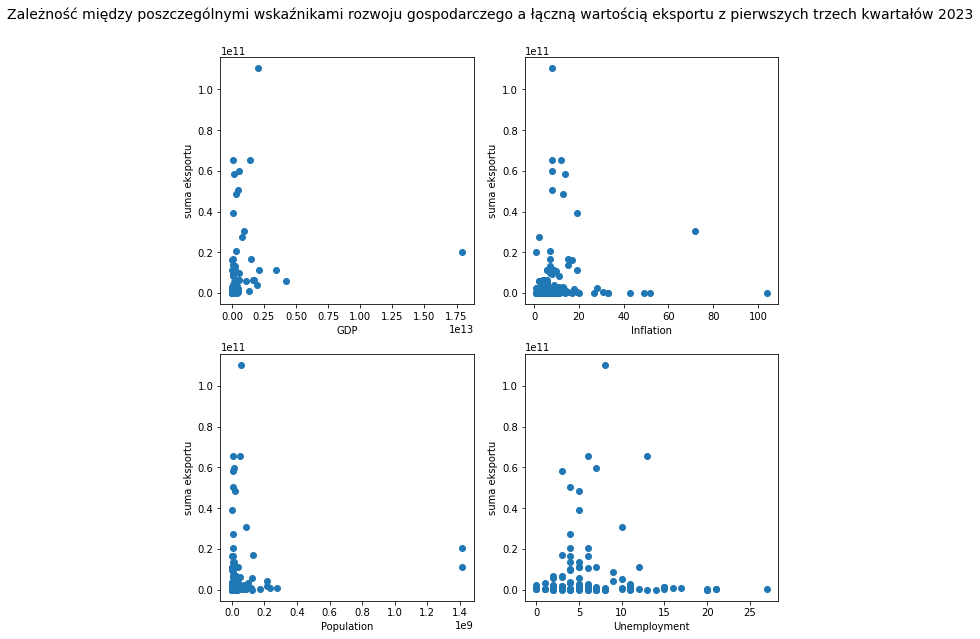

In [224]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        wskaznik = wskazniki_labels[i*2+j]
        wsk_max, wsk_min = df_pandas[wskaznik].min(), df_pandas[wskaznik].max()+1
        ax[i, j].scatter(df_pandas[wskaznik], df_pandas["sum_value"])
        ax[i, j].set_xlabel(wskaznik)
        ax[i, j].set_ylabel("suma eksportu")
fig.suptitle('Zależność między poszczególnymi wskaźnikami rozwoju gospodarczego a łączną wartością eksportu z pierwszych trzech kwartałów 2023', fontsize=14, y=0.95)
plt.show()

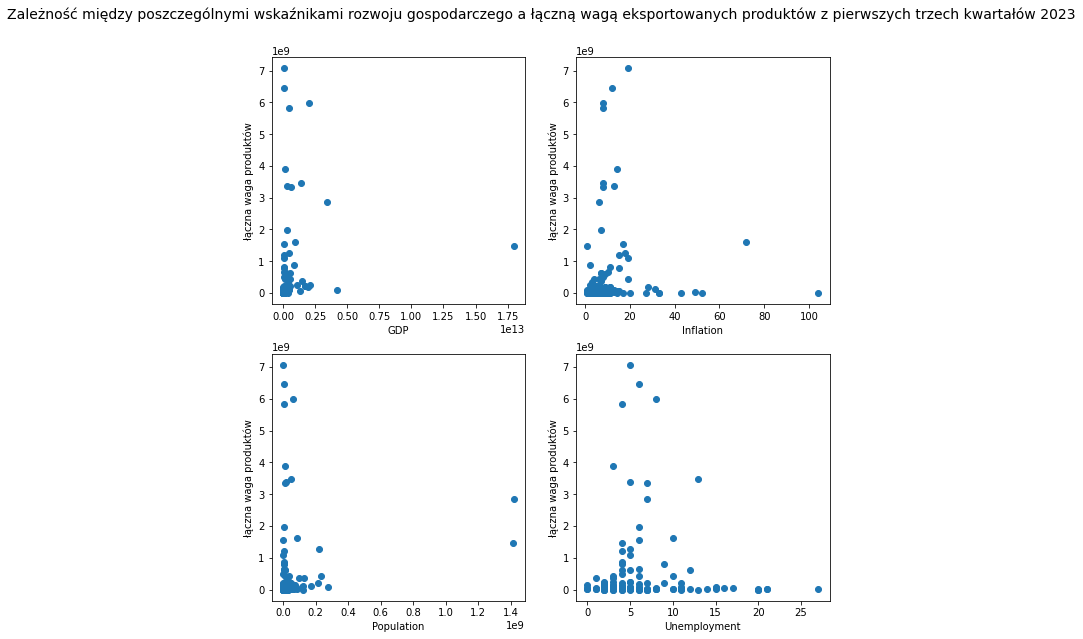

In [227]:
df_pandas = obroty_zsumowane.select(*wskazniki_labels, "sum_weight").na.drop().toPandas()
for wskaznik in wskazniki_labels:
    df_pandas[wskaznik] = df_pandas[wskaznik].astype(float).astype(int)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        wskaznik = wskazniki_labels[i*2+j]
        wsk_max, wsk_min = df_pandas[wskaznik].min(), df_pandas[wskaznik].max()+1
        ax[i, j].scatter(df_pandas[wskaznik], df_pandas["sum_weight"])
        ax[i, j].set_xlabel(wskaznik)
        ax[i, j].set_ylabel("łączna waga produktów")
fig.suptitle('Zależność między poszczególnymi wskaźnikami rozwoju gospodarczego a łączną wagą eksportowanych produktów z pierwszych trzech kwartałów 2023', fontsize=14, y=0.95)
plt.show()